# Training a CNN with Residual Block on CIFAR-10
We will do the following steps in order.
1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

## Dataset

Load and normalizing the CIFA10 training and test datasets using torchvision.

In [2]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

# TODO
# The output of torchvision datasets are PILImage images of range [0,1].
# Convert them to Tensors and normalize

# define train dataset transform
transform_train = transforms.Compose( # 많이 추가해줄수록 -> 처음보는 이미지에 더 강해진다.(원본 이미지가 아래 함수를 다 통과해서 가공된 이미지가 들어감)
                                      # epochs을 많이 늘려야 원본이미지 가공이미지 골고루 많이 들어가게됨
    [transforms.RandomCrop(size=32, padding=4), # random crop, size=32, padding=4 
                                                # 32x32 cifar10 이미지를 패딩4를 하면 40x40이되고 여기서 Random crop을 하면 이미지가 shift된다.(최대4px까지)
     transforms.RandomHorizontalFlip(p=0.5),    # Random Horizontal Flip 상하 반전 (50%의 확률) TestSet에는 상하반전이 없다.
#      transforms.RandomVerticalFlip(p=0.5),      # Random Horizontal Flip  좌우 반전 (50%의 확률)
     transforms.ToTensor(),                     # convert to tensor
     transforms.Normalize(mean, std)            # normalize using dataset mean and std
    ])

# define test dataset transform
transform_test = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean, std), # normalize using dataset mean and std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8) # 메모리 에러 나면 batch사이즈 조절(줄여야 함)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


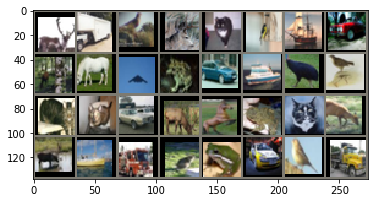

deer, truck, bird, deer, 


In [3]:
# display images
def imshow(img, std=std, mean=mean):
    img = img * std[:,None,None] + mean[:,None,None]  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(''.join('%s, ' % classes[labels[j]] for j in range(4)))

## Define a Convolutional Neural Network

* Network Model
    * Convolution - in_channels=3, out_channels=64, kernel_size=3, padding=1
    * Residual block - num_conv=2, input channel=64, output channel=64, hidden channel=64, kernel_size=3
    * Maxpoling2d - kernel_size=2, stride=2
    * Residual block - num_conv=2, input channel=64, output channel=64, hidden channel=64, kernel_size=3
    * Maxpoling2d - kernel_size=2, stride=2
    * Residual block - num_conv=2, input channel=64, output channel=64, hidden channel=64, kernel_size=3
    * Maxpoling2d - kernel_size=2, stride=2
    * Fully connected layer - in_features: 1024, out_features: 128
    * Fully connected layer - in_features: 128, out_features: 10

* Define and use `ResidualBlock` class.
* Apply ReLU activation function for hidden layers.
* Do not apply softmax activation function for the output layer.
    * softmax activation function are included in the loss function.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, num_conv, in_channels, hidden_channels=None, kernel_size=3):
        super().__init__()

        stride = 1
        out_channels = in_channels
        if hidden_channels is None:
            hidden_channels = in_channels

        if num_conv == 1:
            hidden_channels = out_channels
            
        # TODO
        # make modules and append to list
        module_list = [] 
        for i in range(num_conv):
            if i == 0:
                # append Conv2D layer
                module_list.append(nn.Conv2d(in_channels, hidden_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2)) # kernel_size//2 : padding = same 같다
            elif 0 < i < num_conv - 1:
                # append Conv2D layer
                module_list.append(nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2))
            elif i == num_conv - 1:
                # append Conv2D layer
                module_list.append(nn.Conv2d(hidden_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2))

            module_list.append(nn.ReLU(inplace=True)) # append activation function

        self.module_list = nn.ModuleList(module_list) # layer로 이루어진 list가 들어가면 Autograd가 인식할 수 있는 nn.layer들로 변환

    def forward(self, x):
        # TODO
        # loop over module_list and call modules to compute output
        # add the output with input

        inp = x
        for layer in self.module_list:
            x = layer(x)
        x = x + inp
        
        return x
        
# TODO
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        # create modules (use ResidualBlock)
        self.conv = nn.Conv2d(3, 64, 3, stride=1, padding=3//2)
        self.RB_1 = ResidualBlock(2, 64, 64, 3)
        self.RB_2 = ResidualBlock(2, 64, 64, 3)
        self.RB_3 = ResidualBlock(2, 64, 64, 3)
        self.maxPool2D = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # TODO
        x = F.relu(self.conv(x))
        x = self.RB_1(x)
        x = self.maxPool2D(x)
        x = self.RB_2(x)
        x = self.maxPool2D(x)
        x = self.RB_3(x)
        x = self.maxPool2D(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

net = Net().to(device)

# Test case
# - check the default output of model before training
# - make sure that the definition of layers in your model is correct.
print(net(images.to(device)).shape)
print(str(net))


torch.Size([32, 10])
Net(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (RB_1): ResidualBlock(
    (module_list): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (RB_2): ResidualBlock(
    (module_list): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (RB_3): ResidualBlock(
    (module_list): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (maxPool2D): MaxPool2d(kernel_size=2, stride=2, padding=0

## Training

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam optimizer with learning rate 0.001.

In [ ]:
# TODO
loss_obj = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the network on the training data

In [ ]:
net.train()
## TODO
print('Start Training ')
num_epochs = 10
# for epoch
    running_loss = 0.0
    # for a batch from trainloader
        # batch to gpu

        # forward
        
        # get loss
        
        # backward + optimize

        # print statistics
        running_loss += loss.item()
        print('\r[Epoch {}/{}][itr {}/{}] Loss: {}'.format(epoch+1, num_epochs, i+1, len(trainloader), running_loss/(i+1)), end='')

print('Finished Training')

## Testing

### Show network prediction

In [ ]:
net.eval()

# display ground truth
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# display predicted
with torch.no_grad():
    outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

### Test the network on the test data

#### Accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

#### Accuracy of each class

In [ ]:
class_correct = [0.0] * 10
class_total = [0.0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))